3


INFO:pypsa.linopf:Prepare linear problem
INFO:pypsa.linopf:Total preparation time: 8.26s
INFO:pypsa.linopf:Solve linear problem using Gurobi solver


Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-28
Read LP format model from file C:\Users\RAWADF~1\AppData\Local\Temp\pypsa-problem-l6j2gd93.lp
Reading time = 2.94 seconds
obj: 289080 rows, 131416 columns, 565358 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 289080 rows, 131416 columns and 565358 nonzeros
Model fingerprint: 0x2dc8338c
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [1e+00, 6e+05]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 9e+04]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 144202 rows and 30323 columns
Presolve time: 2.75s
Presolved: 144878 rows, 101093 columns, 523018 nonzeros

Ordering time: 0.13s

Barrier statistics:
 Dense cols : 15
 AA' NZ     : 5.095e+05
 Factor NZ  : 2.227e+06 (roughly 120 MB of memory)
 Factor

INFO:pypsa.linopf:Optimization successful. Objective value: 7.33e+09


Empty DataFrame
Columns: []
Index: [2015-01-01 00:00:00+00:00, 2015-01-01 01:00:00+00:00, 2015-01-01 02:00:00+00:00, 2015-01-01 03:00:00+00:00, 2015-01-01 04:00:00+00:00, 2015-01-01 05:00:00+00:00, 2015-01-01 06:00:00+00:00, 2015-01-01 07:00:00+00:00, 2015-01-01 08:00:00+00:00, 2015-01-01 09:00:00+00:00, 2015-01-01 10:00:00+00:00, 2015-01-01 11:00:00+00:00, 2015-01-01 12:00:00+00:00, 2015-01-01 13:00:00+00:00, 2015-01-01 14:00:00+00:00, 2015-01-01 15:00:00+00:00, 2015-01-01 16:00:00+00:00, 2015-01-01 17:00:00+00:00, 2015-01-01 18:00:00+00:00, 2015-01-01 19:00:00+00:00, 2015-01-01 20:00:00+00:00, 2015-01-01 21:00:00+00:00, 2015-01-01 22:00:00+00:00, 2015-01-01 23:00:00+00:00, 2015-01-02 00:00:00+00:00, 2015-01-02 01:00:00+00:00, 2015-01-02 02:00:00+00:00, 2015-01-02 03:00:00+00:00, 2015-01-02 04:00:00+00:00, 2015-01-02 05:00:00+00:00, 2015-01-02 06:00:00+00:00, 2015-01-02 07:00:00+00:00, 2015-01-02 08:00:00+00:00, 2015-01-02 09:00:00+00:00, 2015-01-02 10:00:00+00:00, 2015-01-02 11:00:00

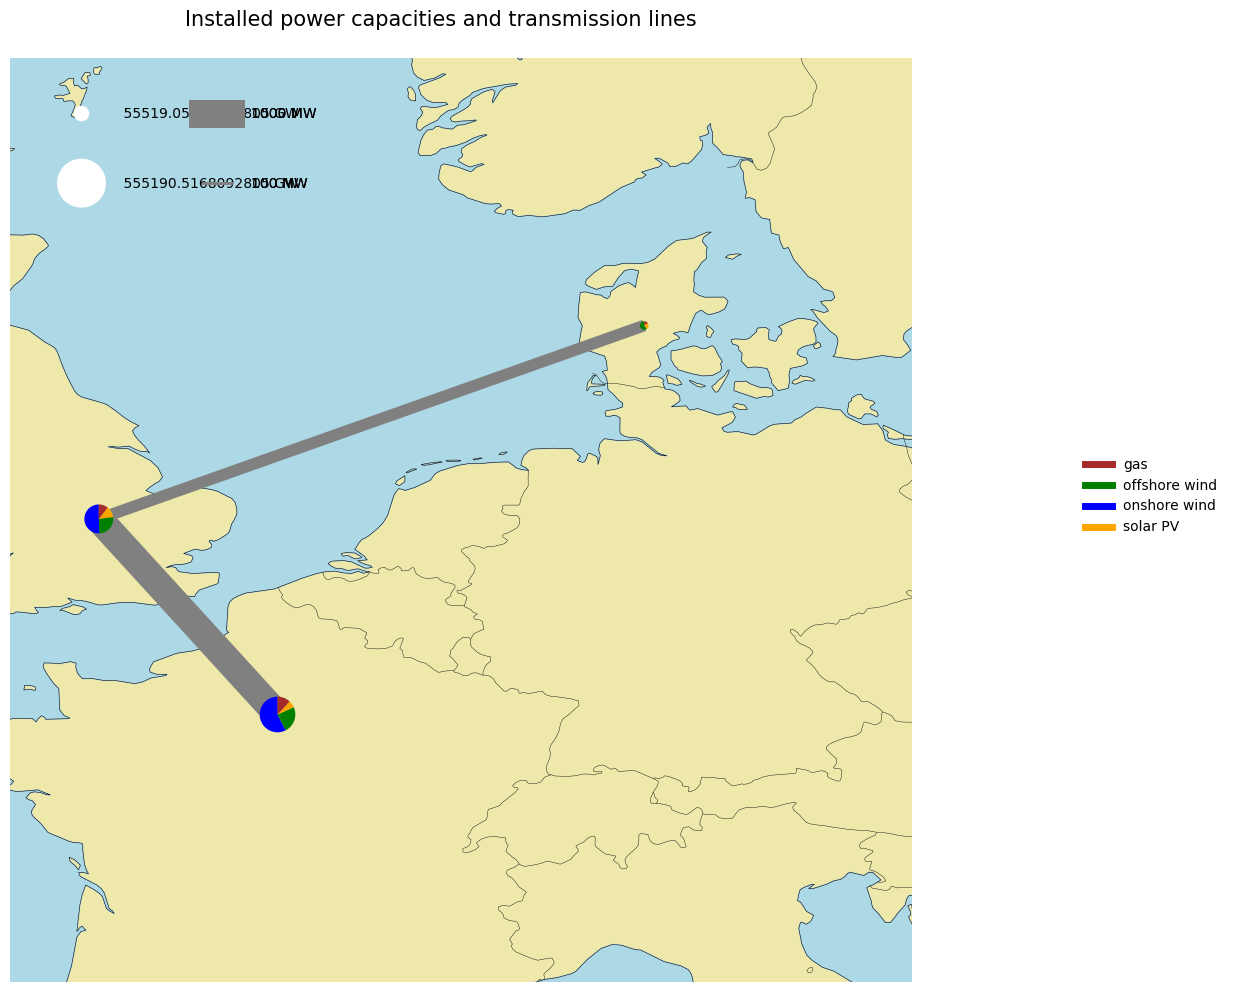

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import math 
import collections
import openpyxl
import matplotlib.pyplot as plt
import io
import plotly.express as px
from sklearn.preprocessing import StandardScaler
import pypsa
from Plotting import plot_map
#from plotting import plot_map
import warnings
warnings.filterwarnings("ignore")

hours_in_2015 = pd.date_range('2015-01-01T00:00Z','2015-12-31T23:00Z', freq='H', tz = 'utc')
network = pypsa.Network()
network.set_snapshots(hours_in_2015)

#Add generators to the network
network.add("Carrier", "onshorewind") # in t_CO2/MWh_th
network.add("Carrier", "offshorewind")
network.add("Carrier", "solar")
network.add("Carrier", "gas", co2_emissions=0.185)

#Defining nodes
nodes = pd.Series(['DNK','FRA','GBR']).values
neighbors =pd.Series(['DNK','FRA']).values
c = list(set(nodes) - set(neighbors))[0]

# longitude for DNK,FRA, and GBR respectively
xs = {'DNK':9.360351562500002, 
     'FRA':2.5048828125000004,
     'GBR':-0.8349609375000001}

# latitude
ys = {'DNK':55.990430,
     'FRA':48.719961222646276,
     'GBR':52.37559917665913}

network.add("Bus",'DNK',x=xs['DNK'],y=ys['DNK'])
network.add("Bus",'FRA',x=xs['FRA'],y=ys['FRA'])
network.add("Bus",'GBR',x=xs['GBR'],y=ys['GBR'])

#Data used
df_elec = pd.read_csv('electricity_demand.csv', sep=';', index_col=0) # in MWh
df_elec.index = pd.to_datetime(df_elec.index) #change index to datatime

#Add load to the network
network.madd("Load",
        nodes, 
        bus=nodes, 
        p_set=df_elec[nodes])

# Add Links from main country (UK) to neighboring countries (FRA and DNK)
network.madd("Link",
     c + " - " + neighbors,
     bus0=c,
     bus1=neighbors,
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=500, # length (in km) between country a and country b
     capital_cost=400*300) # capital cost [EUR/MW/km] * length [km] 

# Links between neighboring countries (FRA and DNK)
network.add("Link",
     neighbors[0] + ' - ' + neighbors[1],
     bus0=neighbors[0],
     bus1=neighbors[1],
     p_nom_extendable=True, # capacity is optimised
     p_min_pu=-1,
     length=1000, # length (in km) between country a and country b
     capital_cost=400*1500) # capital cost [EUR/MW/km] * length [km] 

##Needed data
df_onshorewind = pd.read_csv('onshore_wind_1979-2017.csv', sep=';', index_col=0)
df_onshorewind.index = pd.to_datetime(df_onshorewind.index)
df_offshorewind = pd.read_csv('offshore_wind_1979-2017.csv', sep=';', index_col=0)
df_offshorewind.index = pd.to_datetime(df_offshorewind.index)
df_solar = pd.read_csv('pv_optimal.csv', sep=';', index_col=0)
df_solar.index = pd.to_datetime(df_solar.index)


def annuity(n,r):
    """Calculate the annuity factor for an asset with lifetime n years and
    discount rate of r, e.g. annuity(20,0.05)*20 = 1.6"""

    if r > 0:
        return r/(1. - 1./(1.+r)**n)
    else:
        return 1/n


#Defining capital costs for used technologies
capital_cost_onshorewind = annuity(25,0.08)*52910*(1) # in €/MW 
capital_cost_solar = annuity(25,0.07)*50610*(1) # in €/MW 
capital_cost_offshorewind = annuity(25,0.0875)*65560*(1) # in €/MW 
capital_cost_OCGT = annuity(25,0.07)*97760*(1) # in €/MW
fuel_cost = 22.75 # in €/MWh_th #https://assets.publishing.service.gov.uk/government/uploads/system/uploads/attachment_data/file/1107499/quarterly_energy_prices_uk_september_2022.pdf
efficiency = 0.39
marginal_cost_OCGT = fuel_cost/efficiency # in €/MWh_el

CF_wind = pd.DataFrame()
CF_solar = pd.DataFrame()
CF_offshorewind = pd.DataFrame()
print(len(nodes))
for i in range(len(nodes)):
    CF_wind[nodes[i]] = df_onshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    CF_offshorewind[nodes[i]] = df_offshorewind[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
    CF_solar[nodes[i]] = df_solar[nodes[i]][[hour.strftime("%Y-%m-%dT%H:%M:%SZ") for hour in network.snapshots]]
 
    
network.madd("Generator",
        nodes + " onshorewind",
        bus=nodes,
        p_nom_extendable=True,
        carrier="onshorewind",
        #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
        capital_cost = capital_cost_onshorewind,
        marginal_cost = 0,
        p_max_pu = CF_wind[nodes].values)

network.madd("Generator",
            nodes + " offshorewind",
            bus=nodes,
            p_nom_extendable=True,
            carrier="offshorewind",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_offshorewind,
            marginal_cost = 0,
            p_max_pu = CF_offshorewind[nodes].values)

network.madd("Generator",
            nodes + " solar",
            bus=nodes,
            p_nom_extendable=True,
            carrier="solar",
            #p_nom_max=1000, # maximum capacity can be limited due to environmental constraints
            capital_cost = capital_cost_solar,
            marginal_cost = 0,
            p_max_pu = CF_solar[nodes].values)



network.madd("Generator",
            nodes + " OCGT",
            bus=nodes,
            p_nom_extendable=True,
            carrier="gas",
            #p_nom_max=1000,
            capital_cost = capital_cost_OCGT,
            marginal_cost = marginal_cost_OCGT)


#solve    
network.lopf(network.snapshots, 
             pyomo=False,
             solver_name='gurobi')


print(network.storage_units_t.state_of_charge)

print(network.objective/network.loads_t.p.sum()) # €/MWh
print ((network.generators.p_nom_opt/1000)) # /in GW

tech_colors = {'onshore wind':'blue',
              'offshore wind':'green',
              'solar PV':'orange',
              'gas':'brown',
              }

plot_map(network, tech_colors, threshold=10,components=["generators"], 
             bus_size_factor=5e6, transmission=True)



Link
GBR - DNK     419.282157
GBR - FRA    1144.776625
DNK - FRA       0.000000
Name: p_nom_opt, dtype: float64


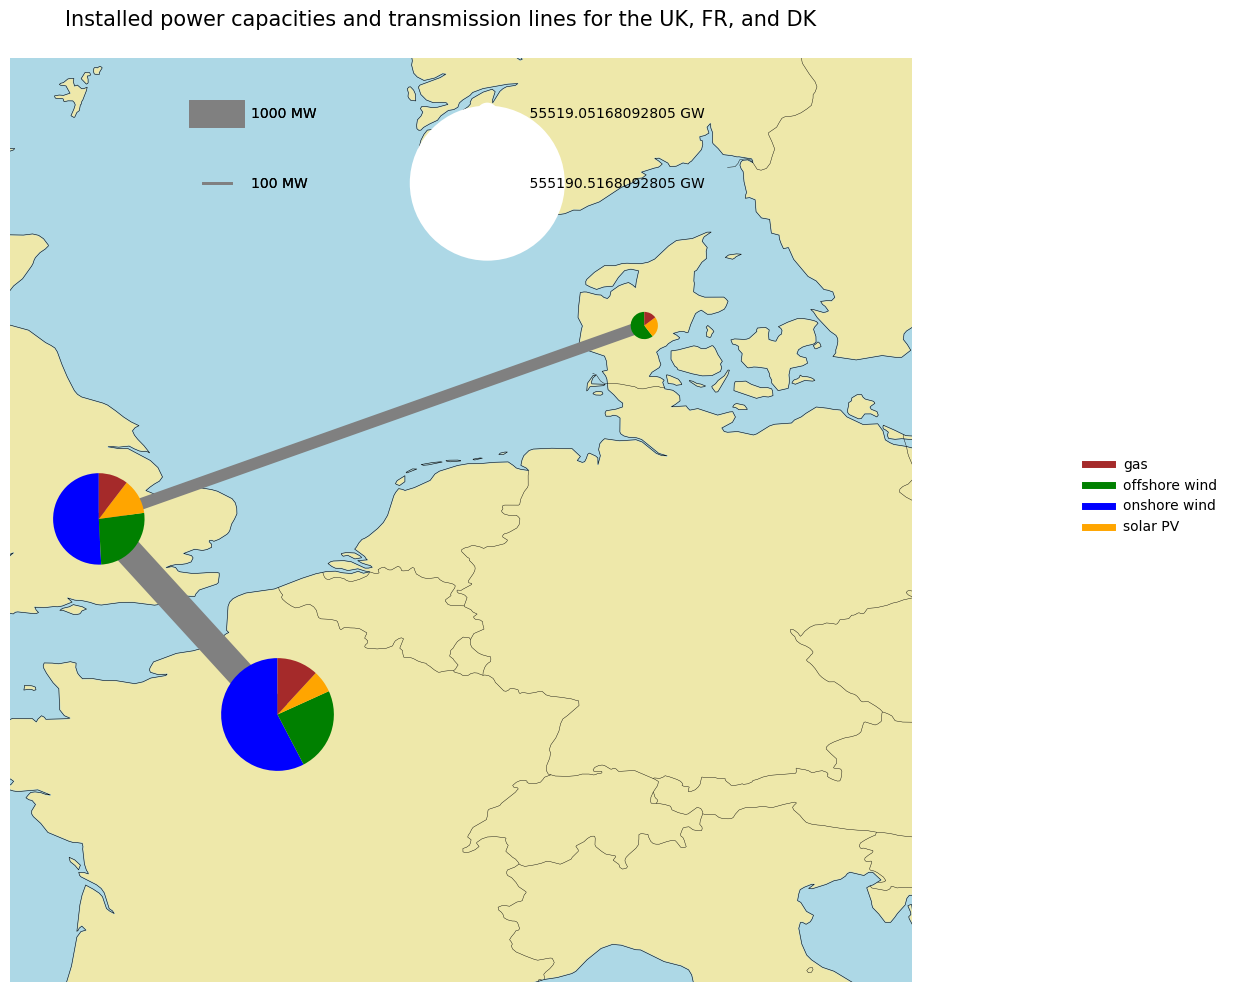

In [3]:
#I did not like the legend in the first figure, so I decided to move their location so that I will get a cleaner figure
from Plotting_modified import plot_map_modified
plot_map_modified(network, tech_colors, threshold=10,components=["generators"], 
             bus_size_factor=5e5, transmission=True)

print ((network.links.p_nom_opt)) # /in MW